In [2]:
import os
import os.path as osp
import sys
import pickle


dataset = 'HF' # {'COCO', 'HF'}

if dataset == 'COCO':
    prFile = '/home/chnxi/Detectron/backfill/COCO_Mask_Detector/coco_2014_minival/test/coco_2014_minival/generalized_rcnn/classwise_pr_curves.pkl'
    saveClsThrshFile = '/home/chnxi/Detectron/backfill/COCO_Mask_Detector/coco_2014_minival/class_thresholds_at_pr.pkl'
elif dataset == 'HF':
    prFile = '/home/chnxi/Detectron/backfill/HF_Detector/furniture_val/test/furniture_val/retinanet/classwise_pr_curves.pkl'
    saveClsThrshFile = '/home/chnxi/Detectron/backfill/HF_Detector/furniture_val/class_thresholds_at_pr.pkl'
    #labelFile = '/media/data/chnxi/HomeFurniture/taxonomy/furniture_58_labels.txt'
    #classes = [l.rstrip() for l in open(labelFile,'r').readlines()]

    
    
d = pickle.load(open(prFile,'rb'))

recallThrs = d['recallThrs']

all_precs = d['clsPrecisions']

all_scores = d['clsScores']

cls_aps = d['clsAPs']

classes = d['classes'][1:] # remove background
print (classes)
print ("recallThrs.shape = {}, all_precs.shape = {}, all_scores.shape = {}".format(recallThrs.shape, all_precs.shape, all_scores.shape))

['armchair', 'bakeware', 'basket', 'bathroom_faucet', 'bathroom_sink', 'bathtub', 'bed', 'bed_linens', 'bench', 'cabinet', 'candle_or_candle_holder', 'ceiling_fan', 'ceiling_light', 'chair', 'clock', 'comforter', 'cooktop', 'cookware', 'crib', 'curtain', 'cushion', 'desk_or_table', 'dinnerware_or_serveware', 'dishwasher', 'drawer_chest', 'fireplace', 'floor_lamp', 'frame_and_picture', 'holiday_decoration', 'kitchen_faucet', 'kitchen_island', 'kitchen_sink', 'ladder_or_stepstool', 'lighting_other', 'microwave', 'mirror', 'nightstand', 'oven', 'paper_decoration', 'pillow', 'pitcher', 'plant_and_pot', 'range_hood', 'refrigerator', 'rug_or_mat', 'shelving', 'shower', 'sofa', 'table_lamp', 'throwpillow', 'toilet', 'towel', 'toy', 'toy_organizer', 'tv_monitor', 'vase', 'wardrobe', 'washer_and_dryer']
recallThrs.shape = (101,), all_precs.shape = (58, 101), all_scores.shape = (58, 101)


In [8]:
showCateg = 'wardrobe'
catid = classes.index(showCateg)
print (recallThrs)
print (all_precs[catid])
print (all_scores[catid])
print (d['clsAPs'][catid])
print ("len(scores) = {}".format(len(set(all_precs[catid]))))

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
[1.         0.71428571 0.71428571 0.71428571 0.71428571 0.71428571
 0.71428571 0.71428571 0.71428571 0.71428571 0.71428571 0.71428571
 0.71428571 0.71428571 0.71428571 0.5483871  0.5483871  0.42222222
 0.33333333 0.33333333 0.33333333 0.30263158 0.2962963  0.25252525
 0.24427481 0.24427481 0.24427481 0.24427481 0.24427481 0.24427481
 0.24427481 0.22147651 0.22077922 0.21621622 0.21621622 0.21621622
 0.21621622 0.21621622 0.21578947 0.21182266 0.21182266 0.20091324
 0.20087336 0.200

Target saving PR thresholds to /home/chnxi/Detectron/backfill/HF_Detector/furniture_val/class_thresholds_at_pr.pkl


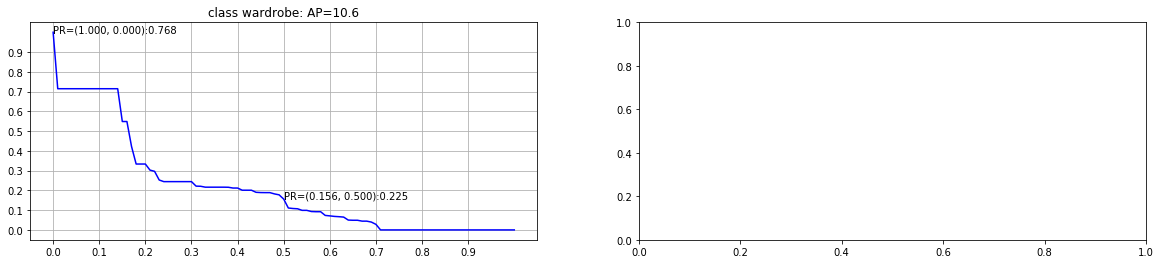

clsThrshAtPrec = {0.9: array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.76778102, 0.        ]), 0.8: array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0

In [13]:
import matplotlib.pyplot as plt
import numpy as np

print ("Target saving PR thresholds to {}".format(saveClsThrshFile))

vis = True
saveThrshFile = False
clsNum = all_precs.shape[0]

classIds = [56] #range(clsNum) #[78]
visClsNum = 1

#clsNum = 10

precList = [0.9, 0.8]
recList = [0.7, 0.5]

clsThrshAtPrec = {}
for p in precList:
    clsThrshAtPrec[p] = np.zeros(clsNum)
    
clsThrshAtRec = {}
for r in recList:
    clsThrshAtRec[r] = np.zeros(clsNum)

def findPrecScoreThrsh(prec, pthrsh, scores):
    if len(np.where(prec >= pthrsh)[0]) > 0:
        (p,i) = min((p,i) for (i,p) in enumerate(prec) if p >= pthrsh)
        return scores[i], p, i
    else: # highest precision didin't reach threshold, take the precision/score at the max precision
        max_prec = max(prec)
        max_prec_idx = np.where(prec==max_prec)[0][0]
        return scores[max_prec_idx], max_prec, max_prec_idx

def findRecScoreThrsh(rec, rthrsh, scores):
    idx = int(rthrsh*100)
    return scores[idx], idx

if vis:
    f, axarr = plt.subplots(int(np.ceil(visClsNum/2)), 2, figsize=(20, 4 * visClsNum))
    plt.axis('on')
    major_ticks = np.arange(0., 1, 0.1) 
for plotid, cid in enumerate(classIds): #range(clsNum-10, clsNum): 
    cls_prec = all_precs[cid,:]
    cls_scores = all_scores[cid,:]
    
    (min_prec,min_prec_idx) = min((p,i) for (i,p) in enumerate(cls_prec) if p > 0)
    maxClsRecall = recallThrs[min_prec_idx]
    score_at_max_cls_recall = cls_scores[min_prec_idx]
    
    #print ("cid={}, min_prec_idx = {}, min_prec = {}, max_recall = {}, score_at_max_cls_recall = {}".format(cid, min_prec_idx, min_prec, maxClsRecall, score_at_max_cls_recall))
    
    for p in precList:
        score_at_p_thrsh, p_at_thrsh, pidx = findPrecScoreThrsh(cls_prec, p, cls_scores)
        clsThrshAtPrec[p][cid] = score_at_p_thrsh
        
    for r in recList:
        score_at_r_thrsh, ridx = findRecScoreThrsh(recallThrs, r, cls_scores)
        clsThrshAtRec[r][cid] = max(score_at_r_thrsh, score_at_max_cls_recall)
        
    #print ("P@{} Score = {}, real precision = {}".format(0.9, score_p_at_thrsh, p_at_thrsh))
    if vis and plotid < visClsNum:
        ax = axarr[plotid]
        ax.set_xticks(major_ticks)                                                       
        ax.set_yticks(major_ticks)                                                       
        ax.plot(recallThrs, cls_prec, 'b-')
        ax.annotate('PR=({:.3f}, {:.3f}):{:.3f}'.format(cls_prec[pidx], recallThrs[pidx], cls_scores[pidx]), xy=(recallThrs[pidx], cls_prec[pidx]))
        ax.annotate('PR=({:.3f}, {:.3f}):{:.3f}'.format(cls_prec[ridx], recallThrs[ridx], cls_scores[ridx]), xy=(recallThrs[ridx], cls_prec[ridx]))  
        ax.set_title('class {}: AP={:.1f}'.format(classes[cid], cls_aps[cid]*100))
        ax.grid()

plt.show()

print ("clsThrshAtPrec = {}".format(clsThrshAtPrec))
print ("clsThrshAtRec = {}".format(clsThrshAtRec))

class_thresholds = {'prec_at':clsThrshAtPrec, 
                    'rec_at':clsThrshAtRec, 
                    'classes': classes,
                     'cls_aps': cls_aps}

if saveThrshFile:
    with open(saveClsThrshFile, 'wb') as f:
        pickle.dump(class_thresholds, f)    
    print ("Saved to {}".format(saveClsThrshFile))


In [4]:
plt.show()